In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt

### В данном эксперименте будем использовать непараметрическую регрессию Надарая-Ватсона из библиотеки statsmodels
####  Для проведения более удобной дальнейшей кроссвалидации, сделаем обертку, над данным методом, чтобы он соответствовал интерфейсу моделей sklearn
#### Данная библтотека сама производит подбор ширины окна, мы можем выбрать подходящий метод подбора окна. Первый метод 'lc' (local constant) окно постоянной длинны для всей выборки, 'll' (local linear estimator) ширина окна  выбирается для каждой точки отдельно

In [2]:
from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.nonparametric.kernel_regression import KernelReg

class KernelRegWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, reg_type='lc'):
        self.model = None
        self.reg_type = reg_type
    
    def fit(self,X,y):
        self.model = KernelReg(y, X, var_type='c'*X.shape[1],
                               reg_type=self.reg_type, bw='cv_ls')
        
        return self
         
    def predict(self,X):
        return self.model.fit(X)[0]


### Перед работой с настоящими данными проведем экспреримент на искуственном примере, дабы проверить правильность работы алгоритма

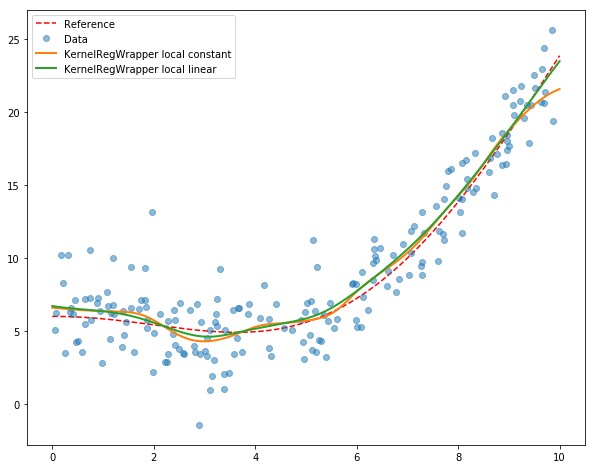

In [3]:
def f(x):
    return 3*np.cos(x/2) + x**2/5 + 3
xs = np.random.rand(200,1) * 10
ys = f(xs) + 2*np.random.randn(*xs.shape)

grid = np.r_[0:10:512j]
plt.figure(figsize=(10,8))

plt.plot(grid, f(grid), 'r--', label='Reference')
plt.plot(xs, ys, 'o', alpha=0.5, label='Data')

reg = KernelRegWrapper(reg_type='lc')
reg.fit(xs, ys)

plt.plot(grid,  reg.predict(grid), 
        label="KernelRegWrapper local constant", linewidth=2)

reg = KernelRegWrapper(reg_type='ll').fit(xs, ys)

plt.plot(grid,  reg.predict(grid), 
        label="KernelRegWrapper local linear", linewidth=2)

plt.legend(loc='best');

### Возьмем датасет с настоящими данными

In [4]:
data = pd.read_csv('Electrical Grid Stability Simulated Data Data Set.csv')
data = data.drop(['p1','stabf'], axis=1)
data = data.sample(300)
data.head()

,tau1,tau2,tau3,tau4,p2,p3,p4,g1,g2,g3,g4,stab
7734,7.715517,2.337593,5.374031,3.197283,-1.567125,-1.462708,-1.266890,0.202366,0.744082,0.160361,0.271004,-0.021041
5636,7.688306,9.881349,3.726803,0.899813,-1.673421,-1.395115,-1.443615,0.202438,0.710622,0.584929,0.629536,-0.015092
9191,6.197947,4.441633,1.208678,3.411057,-0.905050,-1.813330,-1.216976,0.211987,0.273562,0.330806,0.294692,-0.044874
2515,1.117591,1.724218,7.550563,7.179702,-0.756515,-1.878711,-0.941173,0.087444,0.530269,0.963270,0.300166,0.010268
958,9.811977,0.806469,6.292003,8.598982,-0.872922,-0.837131,-0.996463,0.312666,0.588791,0.756210,0.966822,0.038877


In [5]:
X = data.drop(['stab'], axis=1)
y = data[['stab']]

### Будем использовать метод скользящего контроля с разбиением на 5 подвыборок, в качестве метрики - MSE

In [6]:
from sklearn.model_selection import cross_val_score

def evaluate_model(model):
    res = cross_val_score(model, X, y, cv=5, n_jobs=-1, verbose=1, 
                          scoring='neg_mean_squared_error')
    print(-res)
    print('Mean mse csore:', -res.mean())
    print('Std mse csore:', res.std())

### Метод с окном постоянной длинны

In [7]:
evaluate_model(KernelRegWrapper(reg_type='lc'))

[0.00047452 0.00035139 0.00048454 0.00046719 0.00044646]
Mean mse csore: 0.00044482101774185885
Std mse csore: 4.8354781601477074e-05


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.7min finished


### Метод с окном переменной длинны

In [8]:
evaluate_model(KernelRegWrapper(reg_type='ll'))

[0.00062654 0.0003848  0.00026926 0.00027238 0.00086545]
Mean mse csore: 0.00048368685862211925
Std mse csore: 0.00023089474778173336


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  1.6min finished
